In [1]:
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# plt.style.use('fivethirtyeight')
sea.set_style("whitegrid")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
import os
import gc
import time
import copy
import torch
import torch.nn as nn
import model_utils as u
import model_classes as c
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import utils, transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cuda')

In [7]:
# https://pytorch.org/docs/stable/notes/randomness.html
seed = 325
u.set_all_seeds(seed)

In [8]:
PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/"

In [9]:
# https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe
# https://www.analyticsvidhya.com/blog/2021/04/delimiters-in-pandas-read_csv-function/

df_luad = pd.read_csv(PATH+"TCGA.LUAD.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")
df_lusu = pd.read_csv(PATH+"TCGA.LUSC.sampleMap_HiSeqV2_PANCAN.gz", compression = "gzip", sep = "\t")

In [10]:
df_luad

,sample,TCGA-69-7978-01,TCGA-62-8399-01,TCGA-78-7539-01,TCGA-50-5931-11,TCGA-73-4658-01,TCGA-44-6775-01,TCGA-44-2655-01,TCGA-44-3398-01,TCGA-62-8397-01,...,TCGA-75-7025-01,TCGA-55-7726-01,TCGA-L9-A743-01,TCGA-86-8358-01,TCGA-55-6972-01,TCGA-55-7727-01,TCGA-91-6831-01,TCGA-MN-A4N4-01,TCGA-55-8302-01,TCGA-MP-A4TK-01
0,ARHGEF10L,0.125808,0.561708,-0.237592,-1.180492,-0.656192,0.139908,-0.537692,-0.839092,0.677108,...,0.226508,-2.342092,-0.207692,-0.659792,-1.651292,-2.621192,-1.025192,0.070108,0.305608,0.263208
1,HIF3A,-1.294926,6.069174,3.581474,3.927674,-0.525926,-1.497426,-0.021226,0.179974,1.092974,...,2.539674,-1.259526,-0.387226,3.689474,3.509374,1.986874,-1.993426,2.790974,-0.018326,4.657474
2,RNF17,-0.112935,-0.531035,0.592065,0.291065,-0.531035,0.475865,0.071065,-0.531035,-0.531035,...,-0.068235,-0.531035,0.428265,0.202865,0.567665,0.408165,-0.531035,0.440465,-0.531035,0.049365
3,RNF10,-1.411872,-0.228672,-0.108372,-0.043472,-0.156672,-0.605472,0.139328,-0.450172,0.583528,...,-0.451572,0.261228,-0.331772,-0.213372,-0.189472,0.091028,0.492828,0.037428,0.003728,-0.334572
4,RNF11,0.203922,0.052122,-0.499978,0.710822,0.373522,0.129022,0.436522,0.529622,0.314922,...,-0.155778,0.362522,-0.520578,0.031222,-0.966478,0.318322,0.150822,-0.357778,-0.451578,0.156422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,0.863614,0.317114,-1.243086,2.802714,1.110714,0.879814,-0.028286,0.008714,-0.005186,...,0.544614,1.638214,0.381814,-1.080186,-2.139886,-1.495486,0.472314,0.993014,0.634014,1.222714
20526,BCL6B,0.802173,1.079073,-1.283227,2.250473,1.513973,0.126473,0.576073,0.643573,-0.735227,...,0.842873,0.680873,0.642773,0.154673,-0.849427,-0.359227,0.332973,0.570873,-0.909527,0.671573
20527,GSTK1,0.108205,-0.782695,0.034105,-0.540795,-0.454095,-0.797795,0.531305,0.310605,0.204105,...,-0.454195,-0.466595,-0.011995,-0.503195,0.512405,-0.584495,-1.756895,0.506805,-0.114895,-0.189095
20528,SELP,0.595367,3.114267,0.571467,3.985967,2.893167,1.805567,2.445467,2.575967,1.336567,...,2.817667,-0.301333,2.508367,-0.518033,-1.540033,1.663867,-0.275933,-0.073933,0.848867,1.195667


In [11]:
df_lusu

,sample,TCGA-18-3417-01,TCGA-22-4613-01,TCGA-90-7769-01,TCGA-77-A5G1-01,TCGA-77-A5G3-01,TCGA-66-2766-01,TCGA-37-4135-01,TCGA-56-8201-01,TCGA-56-7582-11,...,TCGA-77-8144-01,TCGA-J1-A4AH-01,TCGA-56-7580-01,TCGA-63-A5MY-01,TCGA-33-AASL-01,TCGA-85-A512-01,TCGA-85-8354-01,TCGA-O2-A5IB-01,TCGA-77-7335-01,TCGA-56-7731-11
0,ARHGEF10L,-2.032992,-1.109192,-1.270392,0.054708,-1.344192,-1.145092,-0.737892,-0.619892,-0.050992,...,-2.237692,-1.395092,-1.926792,-1.335292,-0.762292,-1.286992,-1.847792,0.568508,-0.849892,-0.888992
1,HIF3A,-0.775126,-1.023426,-3.254826,0.075174,0.826174,1.306874,-2.036826,-0.015326,2.772874,...,-5.006326,3.974574,3.154774,4.021874,-0.831926,-1.863426,-1.297326,0.025974,-2.414126,4.229474
2,RNF17,0.573765,-0.531035,-0.090835,-0.531035,-0.531035,-0.049535,0.829765,-0.531035,3.204265,...,-0.531035,1.349965,4.157765,1.554065,0.984465,-0.531035,-0.531035,0.084865,0.192865,-0.531035
3,RNF10,0.365228,-0.326772,0.160728,-0.147472,-0.364672,-0.697672,-0.765472,0.068428,-0.010572,...,-0.381072,-0.527472,0.171028,-0.292972,-0.651572,0.020328,-0.280072,-0.009372,0.197228,0.162228
4,RNF11,0.364522,0.308122,0.368322,0.826222,-0.312978,-0.792078,0.583822,-0.573278,0.323522,...,0.075622,-0.513978,-0.604678,0.479122,-0.446678,-0.560978,-0.560278,-0.136278,0.443922,0.344522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20525,PTRF,1.025014,-0.396686,0.094714,1.569614,1.269914,-0.263486,-2.675286,1.638114,2.118814,...,1.972214,0.993014,-0.233586,-0.222586,0.774714,0.434414,1.246914,-2.425586,1.550114,2.468514
20526,BCL6B,-0.381027,-0.781327,-2.267827,-0.409227,-0.542127,-0.932927,-1.847227,0.972273,4.176973,...,-0.010327,-1.413827,-0.132027,-1.714727,-2.306727,-0.491427,-0.070027,-0.734427,0.294773,2.667973
20527,GSTK1,0.839305,-0.732495,-1.137095,-0.003395,-1.324995,-0.113095,0.841305,-0.320395,-0.376795,...,-1.539295,-1.318095,-0.900095,0.251605,0.406205,0.318305,-0.620695,-1.926795,0.369005,-0.264695
20528,SELP,-1.085033,1.733867,-1.210233,1.761467,-1.784433,-0.762733,-2.145733,0.812667,1.800567,...,-3.797533,0.044667,-1.761533,-0.018533,-2.346733,-1.011433,-1.390333,-2.121633,1.909267,3.930867


# Dataset preprocessing

In [12]:
df, labels, columns = u.dataset_preprocess(df_luad, df_lusu)

,label,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-69-7978-01,1,0.125808,-1.294926,-0.112935,-1.411872,0.203922,0.09939,-0.222094,0.504354,-0.423399,...,1.134722,-0.845117,1.760167,-1.28139,0.224623,0.863614,0.802173,0.108205,0.595367,-0.222712
TCGA-62-8399-01,1,0.561708,6.069174,-0.531035,-0.228672,0.052122,-1.20601,-0.338894,1.449854,0.039401,...,-0.286078,-0.055517,-0.028233,0.04801,0.295223,0.317114,1.079073,-0.782695,3.114267,-0.388912
TCGA-78-7539-01,1,-0.237592,3.581474,0.592065,-0.108372,-0.499978,-0.02541,0.163006,0.131654,-0.050899,...,2.209922,-1.587117,1.565367,2.63871,0.049123,-1.243086,-1.283227,0.034105,0.571467,0.233588
TCGA-50-5931-11,1,-1.180492,3.927674,0.291065,-0.043472,0.710822,1.05089,-0.564394,1.683954,0.398701,...,-0.748878,0.900483,1.903567,-1.28139,-0.549277,2.802714,2.250473,-0.540795,3.985967,0.370988
TCGA-73-4658-01,1,-0.656192,-0.525926,-0.531035,-0.156672,0.373522,0.44729,-0.438994,1.831554,-0.423399,...,-0.748878,-0.931417,1.915167,-0.17659,0.042323,1.110714,1.513973,-0.454095,2.893167,0.193788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-85-A512-01,0,-1.286992,-1.863426,-0.531035,0.020328,-0.560978,0.51729,0.519806,-0.748146,-0.423399,...,-0.748878,-1.587117,-0.236033,1.41071,1.653723,0.434414,-0.491427,0.318305,-1.011433,0.392288
TCGA-85-8354-01,0,-1.847792,-1.297326,-0.531035,-0.280072,-0.560278,0.85009,-0.166294,-1.519246,0.602101,...,0.276622,-1.587117,-0.784133,1.46201,0.765023,1.246914,-0.070027,-0.620695,-1.390333,0.918888
TCGA-O2-A5IB-01,0,0.568508,0.025974,0.084865,-0.009372,-0.136278,-1.41811,0.173506,-2.194046,0.622701,...,-0.408378,-1.246617,-1.940533,-1.28139,1.281723,-2.425586,-0.734427,-1.926795,-2.121633,-0.637412
TCGA-77-7335-01,0,-0.849892,-2.414126,0.192865,0.197228,0.443922,0.54789,0.084406,1.015054,-0.423399,...,-0.748878,-1.587117,2.160367,1.19391,0.197023,1.550114,0.294773,0.369005,1.909267,0.117688


# Train Test Split

In [13]:
df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df, labels, train_size=0.9, random_state=seed, stratify=labels)

In [14]:
df = df_xtrain.copy(deep=True)
labels = df_ytrain
df.reset_index(drop=True, inplace=True)
df_xtest.reset_index(drop=True, inplace=True)

# Standardize the train split

In [15]:
input_dim = df.shape[1] 
output_dim = 512

In [16]:
df_scaler = StandardScaler()
df_scaled = df_scaler.fit_transform(df)
df_scaled_xtest = df_scaler.transform(df_xtest)

In [17]:
only_encoder = c.AutoEncoder(input_dim, output_dim).to(device)
only_encoder.load_state_dict(torch.load(PATH+"SECOND_ITERATION/models/XENA_LUNG_GeneExp_Autoencoder.kd", map_location=torch.device('cpu')))
only_encoder = nn.Sequential(*list(only_encoder.children())[:-1])

In [18]:
classifier = c.Classifier(only_encoder, output_dim).to(device)
classifier.load_state_dict(torch.load(PATH+"SECOND_ITERATION/models/XENA_LUNG_GeneExp_Classifier.kd", map_location=torch.device('cpu')))
del only_encoder

---
---
---


In [19]:
print(torch.__version__)

1.8.1


In [20]:
!python --version

Python 3.7.13




---



---



---



In [21]:
# !pip install venn

In [22]:
from captum.attr import IntegratedGradients, GradientShap, DeepLift

In [23]:
def visualize_importances(file_path, algo_name, feature_names, importances, title, plot=True, axis_title="Features (Genes)"):
    
    file_path=file_path+algo_name
    
    x_pos = (np.arange(len(feature_names[:20])))
    importances = importances.detach().cpu().numpy()
    importances = importances[:20]
    if plot:
        plt.figure(figsize=(14,6))
        g=sea.barplot(x_pos, importances)
        g.set_xticks([])
        plt.xlabel(axis_title)
        plt.ylabel('Importance')
        plt.title(title, fontsize='x-large')
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        plt.show()

In [24]:
"""
In this method, we will select  top 1000 genes that are highly correlated, positive as well as negative.
Therefore, for each class (0, 1), we will return 1000 genes in total: 500 most positively correlated, 500 most negatively correlated.
"""

def get_top_genes_from_attributions(attr1, attr0, columns, k):
    
    attr1 = attr1.detach().cpu().numpy()
    attr0 = attr0.detach().cpu().numpy()
       
    mean_attr1 = np.mean(attr1, axis=0).reshape((attr1.shape[1], 1))
    mean_attr0 = np.mean(attr0, axis=0).reshape((attr0.shape[1], 1))
    
    temp_df_1 = pd.DataFrame(mean_attr1, columns=['mean_target_1'])
    temp_df_0 = pd.DataFrame(mean_attr0, columns=['mean_target_0'])
    
    temp_df_1.insert(0, 'genes', columns)
    temp_df_0.insert(0, 'genes', columns)
    
    temp_df_1.sort_values(by=['mean_target_1'], ascending=False, inplace=True)
    temp_df_0.sort_values(by=['mean_target_0'], ascending=False, inplace=True)
    l1 = temp_df_1.head(k)
    l2 = temp_df_1.tail(k)
    algo_top_genes_luad = pd.concat([l1, l2])
    
    l1 = temp_df_0.head(k)
    l2 = temp_df_0.tail(k)
    algo_top_genes_lusu = pd.concat([l1, l2])
    
    algo_top_genes_luad = algo_top_genes_luad.iloc[:,0].values
    algo_top_genes_lusu = algo_top_genes_lusu.iloc[:,0].values
    
    return algo_top_genes_luad, algo_top_genes_lusu

In [25]:

def get_first20_genes_from_attributions(attr1, attr0, columns, k):
    
    attr1 = attr1.detach().cpu().numpy()
    attr0 = attr0.detach().cpu().numpy()
       
    mean_attr1 = np.mean(attr1, axis=0).reshape((attr1.shape[1], 1))
    mean_attr0 = np.mean(attr0, axis=0).reshape((attr0.shape[1], 1))
    
    temp_df_1 = pd.DataFrame(mean_attr1, columns=['mean_target_1'])
    temp_df_0 = pd.DataFrame(mean_attr0, columns=['mean_target_0'])
    
    temp_df_1.insert(0, 'genes', columns)
    temp_df_0.insert(0, 'genes', columns)
    
    temp_df_1.sort_values(by=['mean_target_1'], ascending=False, inplace=True)
    temp_df_0.sort_values(by=['mean_target_0'], ascending=False, inplace=True)
    
    l1 = temp_df_1.head(10)
    _l1 = temp_df_1.tail(10)
    l0 = temp_df_0.head(10)
    _l0 = temp_df_0.tail(10)
    
    top_genes_luad = pd.concat([l1, _l1])
    top_genes_lusu = pd.concat([l0, _l0])
    
#     l0 = temp_df_0.head(20)
    return top_genes_luad, top_genes_lusu

In [26]:
inputs = torch.from_numpy(df_scaled).type(torch.FloatTensor).to(device)

In [27]:
inputs.requires_grad_()

tensor([[ 0.6019, -0.5126,  0.1678,  ...,  1.0776,  0.3724,  0.2021],
        [-1.6375, -1.6656, -0.7694,  ..., -1.2041, -0.1155,  0.3184],
        [-1.1352,  1.0159,  0.1922,  ..., -0.6302, -1.9744, -0.9463],
        ...,
        [ 1.1590,  1.0307, -0.0886,  ...,  1.3593,  0.8653,  0.2026],
        [-0.1419, -1.4646,  1.1835,  ..., -0.3998,  0.3288,  1.4702],
        [-1.4185, -1.5943, -0.7694,  ..., -0.4083, -2.0001,  0.7766]],
       requires_grad=True)

In [28]:
targets = torch.from_numpy(np.array(labels)).type(torch.IntTensor).to(device)

In [29]:
baselines = torch.Tensor(np.zeros(inputs.shape)).to(device)

In [30]:
baselines

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

---
---
---

#  Start the investigation

In [31]:
PATH = "D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/"

In [32]:
full_path = PATH+"SECOND_ITERATION/seed="+str(seed)+"/"

In [33]:
## IntegratedGradients (baselines)

def process_ig(threshold):
    
    u.set_all_seeds(seed)
    classifier.eval()
    ig_algo = IntegratedGradients(classifier)
    ig_algo_attr1, d1 = ig_algo.attribute(inputs, target=1, baselines=baselines, n_steps=15, return_convergence_delta=True)
    ig_algo_attr0, d0 = ig_algo.attribute(inputs, target=0, baselines=baselines, n_steps=15, return_convergence_delta=True)
    print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))
    return ig_algo_attr1, ig_algo_attr0
    
#     ig_top_genes_luad, ig_top_genes_lusu = get_top_genes_from_attributions(ig_algo_attr1, ig_algo_attr0, columns, threshold)
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/ig_top_%s_genes_luad'%(str(seed), str(threshold)), 'w') as fp:
#         for item in ig_top_genes_luad:
#             fp.write("%s\n" % item)
#         print('LUAD Genes written.')
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/ig_top_%s_genes_lusu'%(str(seed), str(threshold)), 'w') as fp:
#         for item in ig_top_genes_lusu:
#             fp.write("%s\n" % item)
#         print('LUSU Genes written.')

In [34]:
# visualize_importances(full_path, 'LUAD_IG', columns, torch.mean(ig_algo_attr1, axis=0), title="Sample representation of Feature Importances computed by Integrated Gradients on LUAD set") ## LUAD genes visualisation
# visualize_importances(full_path, 'LUSU_IG', columns, torch.mean(ig_algo_attr0, axis=0), title="Sample representation of Feature Importances computed by Integrated Gradients on LUSC set") ## LUSU genes visualisation

---

In [35]:
## GradientShap (baselines)

def process_gs(threshold):

    u.set_all_seeds(seed)
    classifier.eval()
    gradshap_algo = GradientShap(classifier)
    gradshap_attr1, d1 = gradshap_algo.attribute(inputs, target=1, baselines=baselines, return_convergence_delta=True)
    gradshap_attr0, d0 = gradshap_algo.attribute(inputs, target=0, baselines=baselines, return_convergence_delta=True)
    print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))
    return gradshap_attr1, gradshap_attr0

#     gradshap_top_genes_luad, gradshap_top_genes_lusu = get_top_genes_from_attributions(gradshap_attr1, gradshap_attr0, columns, threshold)
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/gs_top_%s_genes_luad'%(str(seed), str(threshold)), 'w') as fp:
#         for item in gradshap_top_genes_luad:
#             fp.write("%s\n" % item)
#         print('LUAD Genes written.')
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/gs_top_%s_genes_lusu'%(str(seed), str(threshold)), 'w') as fp:
#         for item in gradshap_top_genes_lusu:
#             fp.write("%s\n" % item)
#         print('LUSU Genes written.')

In [36]:
# visualize_importances(full_path, 'LUAD_GS', columns, torch.mean(gradshap_attr1, axis=0), title="Sample representation of Feature Importances computed by GradientSHAP on LUAD set") ## LUAD genes visualisation
# visualize_importances(full_path, 'LUSU_GS', columns, torch.mean(gradshap_attr0, axis=0), title="Sample representation of Feature Importances computed by GradientSHAP on LUSC set") ## LUSU genes visualisation

---

In [37]:
## DeepLift (baselines)

def process_dl(threshold):
    
    u.set_all_seeds(seed)
    classifier.eval()
    deeplift_algo = DeepLift(classifier)
    deeplift_attr1, d1 = deeplift_algo.attribute(inputs, target=1, baselines=baselines, return_convergence_delta=True)
    deeplift_attr0, d0 = deeplift_algo.attribute(inputs, target=0, baselines=baselines, return_convergence_delta=True)
    print("Delta_1, Delta_0 = {}, {}".format(torch.mean(d1), torch.mean(d0)))
    return deeplift_attr1, deeplift_attr0
    
#     deeplift_top_genes_luad, deeplift_top_genes_lusu = get_top_genes_from_attributions(deeplift_attr1, deeplift_attr0, columns, threshold)
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/dl_top_%s_genes_luad'%(str(seed), str(threshold)), 'w') as fp:
#         for item in deeplift_top_genes_luad:
#             fp.write("%s\n" % item)
#         print('LUAD Genes written.')
#     with open(r'D:/CANCER BIOLOGY/DATASET/TCGA/FROM Xena/SECOND_ITERATION/seed=%s/dl_top_%s_genes_lusu'%(str(seed), str(threshold)), 'w') as fp:
#         for item in deeplift_top_genes_lusu:
#             fp.write("%s\n" % item)
#         print('LUSU Genes written.')

In [38]:
# visualize_importances(full_path, 'LUAD_DL', columns, torch.mean(deeplift_attr1, axis=0), title="Sample representation of Feature Importances computed by DeepLIFT on LUAD set") ## LUAD genes visualisation
# visualize_importances(full_path, 'LUSU_DL', columns, torch.mean(deeplift_attr0, axis=0), title="Sample representation of Feature Importances computed by DeepLIFT on LUSC set") ## LUSU genes visualisation

In [39]:
ig1, ig0 = process_ig(0)
gs1, gs0 = process_gs(0)
dl1, dl0 = process_dl(0)

Delta_1, Delta_0 = 0.00045384567332377697, -0.0005275968281522072
Delta_1, Delta_0 = 0.00534229027107358, -0.009345714002847672
Delta_1, Delta_0 = -1.6087313703394557e-09, -1.1816751310789186e-07


In [40]:
ig_top_genes_luad, ig_top_genes_lusu = get_first20_genes_from_attributions(ig1, ig0, columns, 0)

In [41]:
ig_top_genes_luad

,genes,mean_target_1
5580,CALML3,0.000968
13498,DSC3,0.000935
3476,KRT14,0.000912
13707,CLCA2,0.000897
4728,S100A7,0.000892
15020,KRT6A,0.000873
12228,KRT5,0.000867
4012,KRT16,0.000835
19478,S100A7A,0.000819
4015,KRT13,0.000802


In [42]:
xtiks = np.linspace(-0.0005, 0.0015, 5)

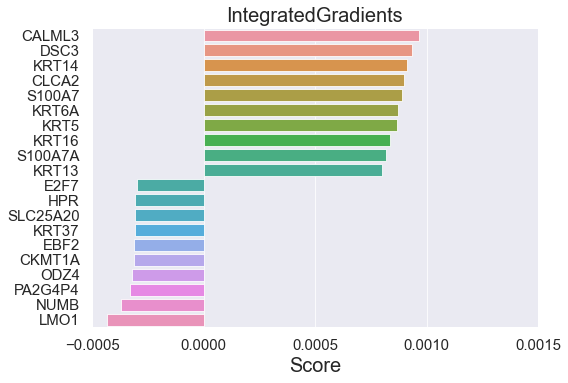

In [82]:
b = sea.barplot(x=ig_top_genes_luad.iloc[:,1], y=ig_top_genes_luad.iloc[:,0])
b.axes.set_title("IntegratedGradients",fontsize=20)
b.set_xlabel("Score",fontsize=20)
b.set_ylabel(None)

b.set_xticks(xtiks)
b.tick_params(labelsize=15)
plt.savefig(PATH+"relevance_score_gene_exp_TOP20_ig.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [44]:
gs_top_genes_luad, gs_top_genes_lusu = get_first20_genes_from_attributions(gs1, gs0, columns, 0)

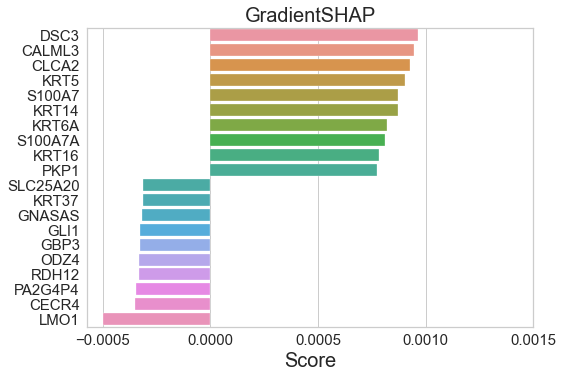

In [45]:

b = sea.barplot(x=gs_top_genes_luad.iloc[:,1], y=gs_top_genes_luad.iloc[:,0])
b.axes.set_title("GradientSHAP",fontsize=20)
b.set_xlabel("Score",fontsize=20)
b.set_ylabel(None)
b.set_xticks(xtiks)
b.tick_params(labelsize=15)
plt.savefig(PATH+"relevance_score_gene_exp_TOP20_gs.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
dl_top_genes_luad, dl_top_genes_lusu = get_first20_genes_from_attributions(dl1, dl0, columns, 0)

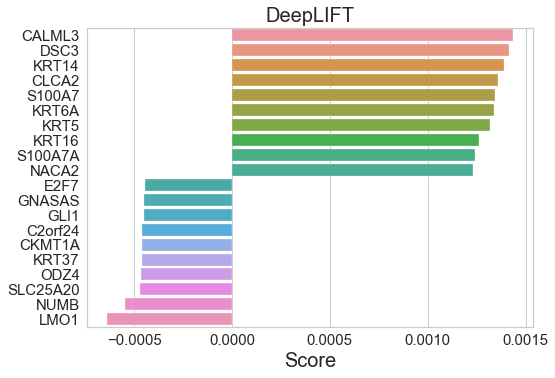

In [47]:
b = sea.barplot(x=dl_top_genes_luad.iloc[:,1], y=dl_top_genes_luad.iloc[:,0])
b.axes.set_title("DeepLIFT",fontsize=20)
b.set_xlabel("Score",fontsize=20)
b.set_ylabel(None)
# b.set_xticks(xtiks)
b.tick_params(labelsize=15)
plt.savefig(PATH+"relevance_score_gene_exp_TOP20_dl.pdf", dpi=300, bbox_inches='tight')
plt.show()

---
---
---

#  Plot  Venns 

In [48]:
# from venn import venn, pseudovenn

In [49]:
# genes_dict_luad = {
    
#     'IntegratedGrad':set(ig_top_genes_luad),
#     'GradShap': set(gradshap_top_genes_luad),
#     'DeepLift': set(deeplift_top_genes_luad),
# }
# venn(genes_dict_luad, cmap='prism', hint_hidden=False, figsize=(11,11), legend_loc="upper left")
# plt.title("Intersection of LUAD genes using IntegratedGradients, GradientSHAP and DeepLIFT")
# plt.savefig(PATH+"project_summary_seed_wise/seed="+str(seed)+"/luad_venn", dpi=300, bbox_inches='tight')
# plt.show()
# # pseudovenn(genes_dict_luad,)

In [50]:
# genes_dict_lusu = {
    
#     'IntegratedGrad':set(ig_top_genes_lusu),
#     'GradShap': set(gradshap_top_genes_lusu),
#     'DeepLift': set(deeplift_top_genes_lusu),
# }
# venn(genes_dict_lusu, cmap='winter', hint_hidden=False, figsize=(11,11), legend_loc="upper left")
# plt.title("Intersection of LUSC genes using IntegratedGradients, GradientSHAP and DeepLIFT")
# plt.savefig(PATH+"project_summary_seed_wise/seed="+str(seed)+"/lusu_venn", dpi=300, bbox_inches='tight')
# plt.show()
# # pseudovenn(genes_dict_lusu, cmap='Spectral_r', hint_hidden=False, figsize=(11,11), legend_loc="upper left")

---
---
---

# Identify common genes from all the methods and save them

In [51]:
# common_luad_genes =  set(deeplift_top_genes_luad) & set(ig_top_genes_luad) & set(gradshap_top_genes_luad)
# common_lusu_genes =  set(deeplift_top_genes_lusu) & set(ig_top_genes_lusu) & set(gradshap_top_genes_lusu)

In [52]:
# common_genes = common_luad_genes.union(common_lusu_genes)

In [53]:
# len(common_genes)

In [54]:
# common_genes

In [55]:
# u.write_seed_genes(PATH, seed, common_genes)

---
---
---

#  Evaluate these common genes (not necessary, but can do)

In [56]:
# epochs = 100
# learning_rate = 1e-4
# batch_size_df = 64

In [57]:
# sklearn_classifiers = [
    
#     MLPClassifier(hidden_layer_sizes=(150, 75, 25), random_state=seed, batch_size=batch_size_df, verbose=False, learning_rate_init=learning_rate, max_iter = epochs),  ## predict_proba
#     LogisticRegression(random_state=seed, max_iter=epochs, solver='saga'),  ## predict_proba
#     RandomForestClassifier(max_depth=8, random_state=seed), ## predict_proba
#     SVC(kernel='rbf', random_state=seed), ## decision_func
# ]

In [58]:
# ## https://stackoverflow.com/questions/40636514/selecting-columns-by-list-and-columns-are-subset-of-list

# df_intersect = df[df.columns.intersection(common_genes)]
# df_xtest_intersect = df_xtest[df_xtest.columns.intersection(common_genes)]

In [59]:
# df_intersect_scaler = StandardScaler()
# df_intersect_scaled = df_intersect_scaler.fit_transform(df_intersect)
# df_intersect_scaled_xtest = df_intersect_scaler.transform(df_xtest_intersect)

In [60]:
# list_fit_train_per_algo=[]
# list_fit_test_per_algo=[]
# models=('MLP','LR', 'RF', 'SVC')
# for classifier in (sklearn_classifiers):
#     classifier.fit(df_intersect_scaled, df_ytrain)
#     list_fit_train_per_algo.append(classifier.score(df_intersect_scaled, df_ytrain))
#     list_fit_test_per_algo.append(classifier.score(df_intersect_scaled_xtest, df_ytest))

In [61]:
# u.plot_train_test_k_fold_accuracy(
#     list_fit_train_per_algo,
#     list_fit_test_per_algo,
#     N=4, 
#     width=0.45,
#     width_mult=1,
#     fig_size=(12, 8), 
#     title='Accuracy score of Various Algorithms on Train/Test Split',
#     x_ticks=models,
#     legends=('Train', 'Test'),
#     file_path=PATH+"project_summary_seed_wise/seed="+str(seed)+"/interpretation_results"
# )

In [62]:
# # k = [50, 100, 150]
# for threshold in k:
#     print('Threshold value: ',threshold)
#     process_ig(threshold)
#     process_gs(threshold)
#     process_dl(threshold)
#     print('========================================')

In [63]:
# process_ig(threshold)
# process_gs(threshold)
# process_dl(threshold)